In [9]:
def stringToList(input):
  lst = []
  for i in input:
    l = list(map(float, i.split(" ")))
    lst.append(l)
  return lst

In [8]:
def moodNamePrintFromLabel(n):
  if n == 0: result = 'Angry '
  elif n == 1: result = 'Disgust '
  elif n == 2: result = 'Fear'
  elif n == 3: result = 'Happy'
  elif n == 4: result = 'Sad'
  elif n == 5: result = 'Surprise'
  elif n == 6: result = 'Neutral'
  return result



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np

In [10]:

data = pd.read_csv('/content/drive/My Drive/projects/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/projects/test.csv')

**processing the data**

In [28]:
X = data['pixels']
Y = np.array(data['emotion'])

x_test_data = np.array(test_data['pixels'])

X = np.array(stringToList(X))/255.0
X = np.reshape(X, (28709, 48,48,1))

x_test_data = np.array(stringToList(x_test_data))
x_test_data = np.reshape(x_test_data, (7178,48,48,1)) /255.0


In [ ]:
print(X.shape)
print(Y.shape)

(28709, 48, 48, 1)
(28709,)


**data splitting to test and training set**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(22967, 48, 48, 1)
(22967,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization

In [ ]:
model = Sequential()
#1st convo
model.add(Conv2D(96, (3,3), input_shape = (48,48,1)))
model.add(Activation('relu'))
#polling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())


#2nd convo
model.add(Conv2D(256, (3,3)))
model.add(Activation('relu'))
#polling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

#3rd convo
model.add(Conv2D(384, (3,3)))
model.add(Activation('relu'))
#polling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

#4th convo
model.add(Conv2D(256, (3,3)))
model.add(Activation('relu'))
#polling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())




#passing through dense layer
model.add(Flatten())

#1st dense layer
model.add(Dense(1024))
model.add(Activation('relu'))
#dropout
model.add(BatchNormalization())
model.add(Dropout(0.4))


#2nd dense layer
model.add(Dense(1024))
model.add(Activation('relu'))
#dropout
model.add(BatchNormalization())
model.add(Dropout(0.4))


#3rd dense layer
model.add(Dense(256))
model.add(Activation('relu'))
#dropout
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Activation('relu'))


#output layer
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "adam",
              metrics = ['sparse_categorical_accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

In [ ]:
model.save('/content/drive/My Drive/projects/model.h5')

**Loading the saved mood detection model from google drive**

In [11]:
from keras.models import load_model
loaded_model = load_model('/content/drive/My Drive/projects/model.h5')

In [ ]:
score = loaded_model.evaluate(x_test, y_test, verbose=1)

180/180 [==============================] - 37s 203ms/step - loss: 0.6828 - sparse_categorical_accuracy: 0.7654


**Taking input as image and videos and detecting faces and getting the face portion. Then passing these faces to the model and getting the mood detection output.**

In [112]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


def videoToMoodDetection(video_path):
  #video_cap = cv2.VideoCapture(0)
  video_cap = cv2.VideoCapture(video_path)

  while (video_cap.isOpened()):
    ret, frame = video_cap.read()

    Gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_casecade.detectMultiScale(Gray_img, 1.3, 5)

    for (x,y,w,h) in faces:
      pxl_lst = []
      for i in range(y, y+h):
        lst = []
        for j in range(x, x+w):
          lst.append(Gray_img[i][j])
        pxl_lst.append(lst)
      single_face = np.array(pxl_lst)
      
      
      resized_img = cv2.resize(single_face, (48,48), interpolation = cv2.INTER_AREA)

      #printing the 48*48 pixel images which will be passed to the model
      cv2_imshow(resized_img)
      
      #resize for passing to the model
      resized_img = np.reshape(resized_img,(1,48,48,1))/255.0

      #passing to model
      result = np.argmax(loaded_model.predict(resized_img), axis=-1)
      if result is not None:
        print(moodNamePrintFromLabel(result))
  


def imageToMoodDetection(img_path):

  img = cv2.imread(img_path)

  Gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_casecade.detectMultiScale(Gray_img, 1.3, 3)

  for (x,y,w,h) in faces:
      pxl_lst = []
      for i in range(y, y+h):
        lst = []
        for j in range(x, x+w):
          lst.append(Gray_img[i][j])
        pxl_lst.append(lst)
      single_face = np.array(pxl_lst)
      single_face = np.reshape(single_face,(h,w,))
  
      resized_img = cv2.resize(single_face, (48,48), interpolation = cv2.INTER_AREA)
      cv2_imshow(resized_img)
      print(resized_img.shape)
      resized_img = np.reshape(resized_img,(1,48,48,1))/255.0

      #passing to model
      result = np.argmax(loaded_model.predict(resized_img), axis=-1)
      if result is not None:
        print(moodNamePrintFromLabel(result))

  
  
  
  



[[43 34 29 ... 26 31 37]
 [33 29 27 ... 24 29 35]
 [24 25 27 ... 22 25 30]
 ...
 [50 50 51 ... 46 45 47]
 [50 51 53 ... 50 49 49]
 [53 51 51 ... 47 48 49]]


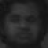

(48, 48)
Happy
[[ 68  45  39 ...  38  38  38]
 [ 65  44  40 ...  38  38  38]
 [ 60  46  43 ...  38  38  38]
 ...
 [192 198 199 ... 156 148 150]
 [182 188 184 ... 150 145 146]
 [162 161 169 ... 152 147 144]]


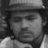

(48, 48)
Sad
[[ 29  33  36 ... 127 144 178]
 [ 27  33  32 ... 138 143 174]
 [ 29  29  28 ... 144 138 153]
 ...
 [ 20  21  21 ...  51  46  50]
 [ 22  20  18 ...  46  46  46]
 [ 22  20  18 ...  57  51  43]]


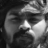

(48, 48)
Angry 


In [110]:
imageToMoodDetection('/content/DSC_2693.NEF.jpg')

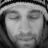

Neutral


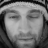

Neutral


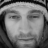

Neutral


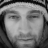

Neutral


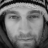

Neutral


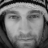

Neutral


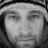

Neutral


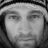

Neutral


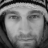

Neutral


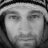

Neutral


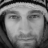

Neutral


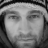

Neutral


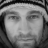

Neutral


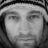

Neutral


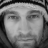

Neutral


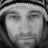

Neutral


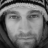

Neutral


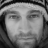

Neutral


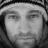

Neutral


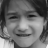

Happy


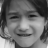

Happy


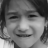

Happy


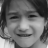

Happy


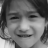

Happy


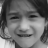

Happy


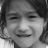

Happy


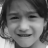

Happy


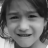

Happy


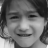

Happy


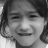

Happy


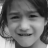

Happy


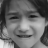

Happy


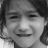

Happy


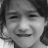

Happy


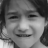

Happy


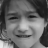

Happy


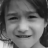

Happy


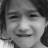

Happy


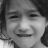

Happy


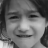

Sad


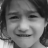

Sad


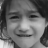

Happy


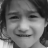

Sad


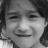

Happy


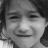

Happy


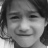

Happy


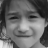

Happy


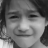

Happy


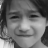

Happy


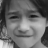

Sad


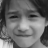

Happy


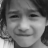

Happy


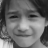

Happy


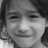

Sad


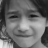

Happy


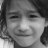

Happy


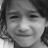

Happy


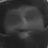

Happy


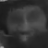

Happy


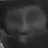

Happy


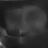

Happy


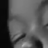

Happy


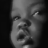

Angry 


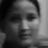

Sad


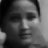

Sad


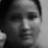

Sad


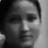

Sad


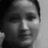

Happy


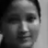

Happy


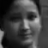

Sad


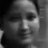

Sad


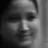

Happy


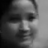

Happy


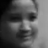

Happy


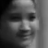

Happy


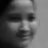

Happy


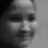

Happy


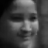

Angry 


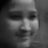

Sad


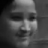

Sad


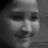

Sad


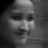

Sad


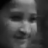

Sad


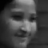

Sad


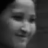

Sad


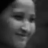

Sad


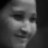

Angry 


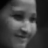

Angry 


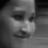

Sad


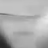

Happy


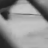

Surprise


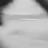

Happy


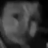

Sad


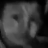

Sad


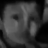

Sad


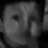

Sad


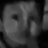

Sad


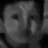

Sad


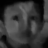

Sad


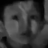

Sad


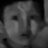

Sad


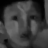

Sad


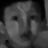

Neutral


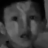

Neutral


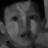

Neutral


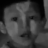

Neutral


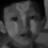

Neutral


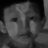

Neutral


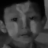

Neutral


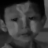

Neutral


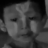

Neutral


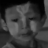

Neutral


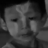

Neutral


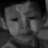

Neutral


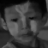

Neutral


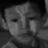

Neutral


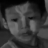

Neutral


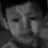

Sad


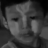

Sad


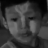

Neutral


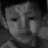

Neutral


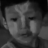

Sad


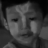

Neutral


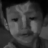

Sad


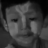

Sad


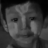

Sad


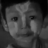

Neutral


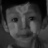

Neutral


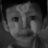

Neutral


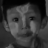

Neutral


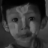

Neutral


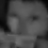

Happy


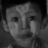

Neutral


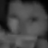

Happy


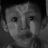

Neutral


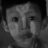

Neutral


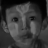

Neutral


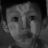

Neutral


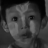

Neutral


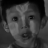

Neutral


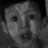

Neutral


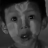

Neutral


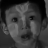

Sad


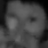

Happy


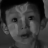

Neutral


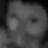

Happy


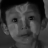

Neutral


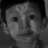

Neutral


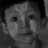

Neutral


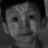

Neutral


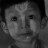

Neutral


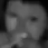

Happy


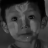

Neutral


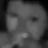

Happy


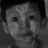

Neutral


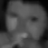

Happy


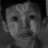

Neutral


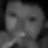

Happy


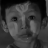

Neutral


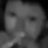

Happy


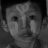

Neutral


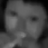

Happy


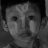

Neutral


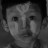

Neutral


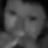

Happy


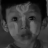

Neutral


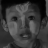

Happy


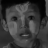

Fear


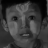

KeyboardInterrupt: ignored

In [115]:
videoToMoodDetection('/content/video.mp4')

**pixel to image**

(48, 48, 1)
(48, 48)


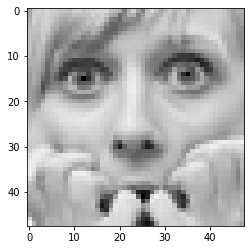

In [ ]:
import matplotlib.pyplot as plt

single_image = np.array(x_test_data[13]*255)
print(single_image.shape)
single_image = np.reshape(single_image,(48,48),order = 'C')
print(single_image.shape)
plt.imshow(single_image, cmap='gray', vmin=0, vmax=255)
# s_img = np.array(single_image, shape=(48,48))